In [2]:
!pip install yfinance
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=7d2f766430959996be3c200906e1e74c08f99a21c1104e20b7101b2bac75f459
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import pandas_ta as ta
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings

<ipython-input-3-ad3d5a0a5235>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')


Running on TPU  ['10.77.52.18:8470']


In [5]:
# If TPU found, we set up the distribution strategy
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Preprocessing methods

In [6]:
def calculate_change(df,column='Close',name='Close_diff'):
  df[name] = df[column].shift(-1) - df[column]
  return df

In [7]:
def calcualte_ti(df,column='Close'):
  if(column in df.columns):
    df[f'{column}_SMA']=ta.sma(df[column],length=15)
    df[f'{column}_RSI']=ta.rsi(df[column], length=15)
    df[f'{column}_EMAF']=ta.ema(df[column], length=20)
    df[f'{column}_EMAM']=ta.ema(df[column], length=100)
    df[f'{column}_EMAS']=ta.ema(df[column], length=150)
    macd = ta.macd(df[column])
    df[f'{column}_MACD'] = macd['MACD_12_26_9']
    df[f'{column}_MACD_Signal'] = macd['MACDs_12_26_9']
    df[f'{column}_MACD_Histogram'] = macd['MACDh_12_26_9']
  return df

In [8]:
def calculate_percentage_change(df,columns):
  for column in columns:
    if column in df.columns:
      # name = f'{column}_pct_change'
      df[f'{column}_pct_change'] = df[column].pct_change()
  return df

In [9]:
def drop_columns(df,columns=['Open','High','Low','Volume' ,'Dividends','Stock Splits']):
  df.drop(columns=columns,axis=0,inplace=True)
  return df

In [10]:
# last_entry = df[-1:]

In [11]:
def dropna(df,axis=1):
  df.dropna(axis=axis,inplace=True)
  return df

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
# scaler.fit(df)
def minmax_scaling(df,columns):
  df[columns] = scaler.fit_transform(df[columns])
  return df

In [13]:
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))

## Preprocessing pipeline

In [14]:
BTC_Ticker = yf.Ticker("BTC-USD")
df = BTC_Ticker.history(period="max")
df = (df.pipe(calcualte_ti,column='Close')
            .pipe(drop_columns,columns=['Dividends','Stock Splits','Close','Open','Low','High','Volume'])
            .pipe(calculate_percentage_change,columns=df.columns)
            .pipe(drop_columns,columns=['Close_SMA','Close_RSI','Close_EMAF','Close_EMAM','Close_EMAS','Close_MACD','Close_MACD_Signal','Close_MACD_Histogram'])
            .pipe(dropna,axis=0)
            .pipe(minmax_scaling,columns=df.columns)
        )

In [15]:
df.head()

,Close_SMA_pct_change,Close_RSI_pct_change,Close_EMAF_pct_change,Close_EMAM_pct_change,Close_EMAS_pct_change,Close_MACD_pct_change,Close_MACD_Signal_pct_change,Close_MACD_Histogram_pct_change
Date,,,,,,,,
2015-02-14 00:00:00+00:00,0.446099,0.496806,0.459919,0.158546,0.103145,0.958936,0.677476,0.173836
2015-02-15 00:00:00+00:00,0.404040,0.268979,0.368613,0.122667,0.077551,0.959035,0.677381,0.172426
2015-02-16 00:00:00+00:00,0.372004,0.373893,0.364119,0.122465,0.077427,0.959044,0.677350,0.172391
2015-02-17 00:00:00+00:00,0.367460,0.431771,0.398496,0.139964,0.090036,0.958951,0.676762,0.172636
2015-02-18 00:00:00+00:00,0.378529,0.340690,0.368588,0.129111,0.082333,0.959022,0.676687,0.172367


## Split dataset

In [16]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]
df_train = df[df.index.values < last_20pct]
df_val = df[(df.index.values >= last_20pct) & (df.index.values < last_10pct)]
df_test = df[(df.index.values >= last_10pct)]

In [17]:
df_train.shape

(2475, 8)

In [18]:
print('Training data shape: {}'.format(df_train.shape))
print('Validation data shape: {}'.format(df_val.shape))
print('Test data shape: {}'.format(df_test.shape))

Training data shape: (2475, 8)
Validation data shape: (309, 8)
Test data shape: (309, 8)


Text(0.5, 0, 'Date')

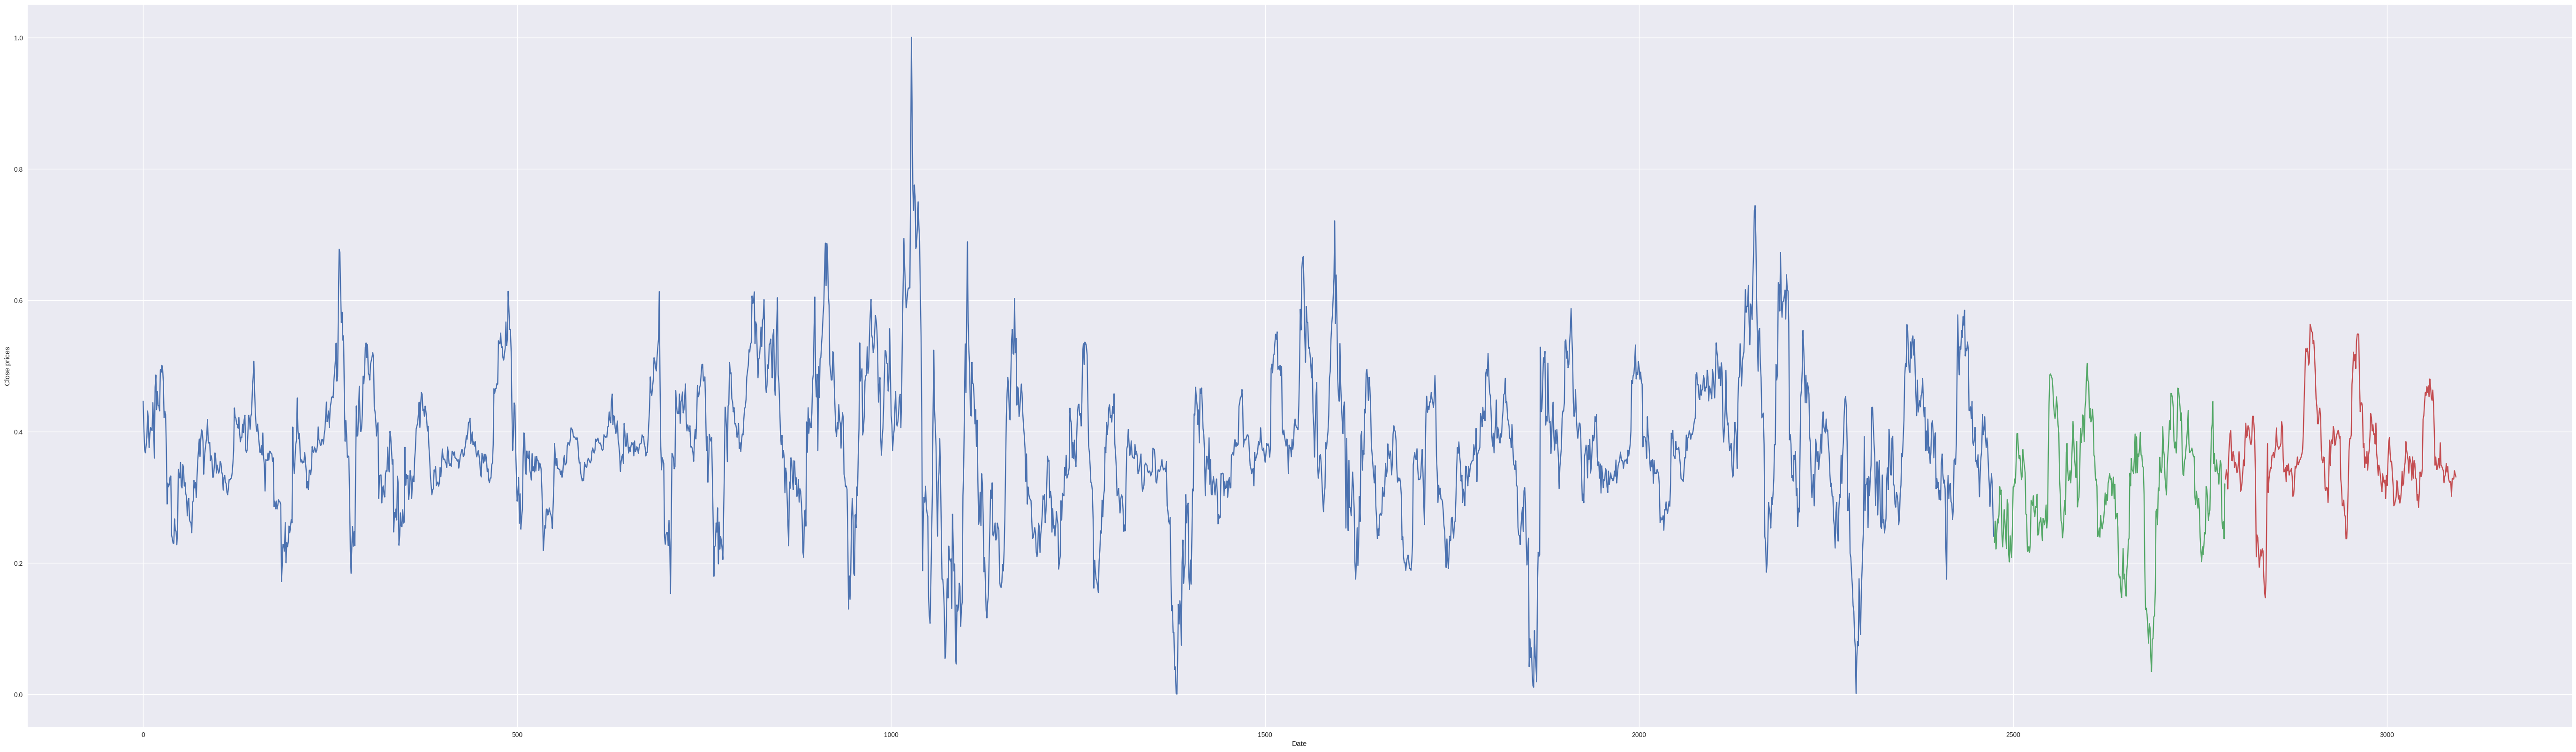

In [19]:
plt.figure(figsize=(70,20))
plt.plot(np.arange(df_train.shape[0]),df_train['Close_SMA_pct_change'],label='Training data')
plt.plot(np.arange(df_train.shape[0],df_train.shape[0]+df_val.shape[0]),df_val['Close_SMA_pct_change'],label='Validation data')
plt.plot(np.arange(df_train.shape[0]+df_val.shape[0],df_train.shape[0]+df_val.shape[0]+df_test.shape[0]),df_test['Close_SMA_pct_change'],label='Test data')

plt.ylabel('Close prices')
plt.xlabel('Date')


## Create sequences

In [20]:
def create_sequences(df,target_columns='Close_SMA_pct_change',seq_len=128):
  X_seq, y_seq = [], []
  X,y = df.values, df[target_columns].values
  for i in range(seq_len, len(df)):
    X_seq.append(X[i-seq_len:i])
    y_seq.append(y[i])
  X_seq, y_seq = np.array(X_seq), np.array(y_seq)
  return X_seq,y_seq

In [21]:
seq_len = 128
# Training data
X_train, y_train = create_sequences(df_train)

# Validation data
X_val, y_val = create_sequences(df_val)

# Test data
X_test, y_test = create_sequences(df_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (2347, 128, 8) (2347,)
Validation set shape (181, 128, 8) (181,)
Testing set shape (181, 128, 8) (181,)


# Modeling

## Layers

In [34]:

class Time2Vector(keras.layers.Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

class SingleAttention(keras.layers.Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = keras.layers.Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = keras.layers.Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = keras.layers.Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out

#############################################################################

class MultiAttention(keras.layers.Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
    self.linear = keras.layers.Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

#############################################################################

class TransformerEncoder(keras.layers.Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = keras.layers.Dropout(self.dropout_rate)
    self.attn_normalize = keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = keras.layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = keras.layers.Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = keras.layers.Dropout(self.dropout_rate)
    self.ff_normalize = keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

## Build model

In [22]:
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
n_features = X_train.shape[-1]
n_output = 1

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  # attn_layer4 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = keras.layers.Input(shape=(seq_len, n_features))
  x = time_embedding(in_seq)
  x = keras.layers.Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  # x = attn_layer4((x, x, x))
  x = keras.layers.GlobalAveragePooling1D(data_format='channels_first')(x)
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  out = keras.layers.Dense(n_output, activation='linear')(x)

  model = keras.models.Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


# Training

In [38]:
batch_size = 32
version='1.2'

with tpu_strategy.scope():
  model = create_model()
  callback = tf.keras.callbacks.ModelCheckpoint(f'model{version}.hdf5',
                                              monitor='val_loss',
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

model = tf.keras.models.load_model(f'/content/model{version}.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


################################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)


Epoch 1/35
74/74 [==============================] - ETA: 0s - loss: 0.0282 - mae: 0.1225 - mape: 184920.4688
Epoch 1: val_loss improved from inf to 0.01438, saving model to Transformer+TimeEmbedding4.hdf5
74/74 [==============================] - 136s 622ms/step - loss: 0.0282 - mae: 0.1225 - mape: 184920.4688 - val_loss: 0.0144 - val_mae: 0.0906 - val_mape: 53.2948
Epoch 2/35
73/74 [============================>.] - ETA: 0s - loss: 0.0132 - mae: 0.0866 - mape: 162721.6250
Epoch 2: val_loss did not improve from 0.01438
74/74 [==============================] - 4s 57ms/step - loss: 0.0132 - mae: 0.0866 - mape: 161959.1094 - val_loss: 0.0150 - val_mae: 0.0933 - val_mape: 54.5728
Epoch 3/35
73/74 [============================>.] - ETA: 0s - loss: 0.0129 - mae: 0.0859 - mape: 144958.7969
Epoch 3: val_loss improved from 0.01438 to 0.01265, saving model to Transformer+TimeEmbedding4.hdf5
74/74 [==============================] - 7s 102ms/step - loss: 0.0128 - mae: 0.0858 - mape: 144279.5000 - v

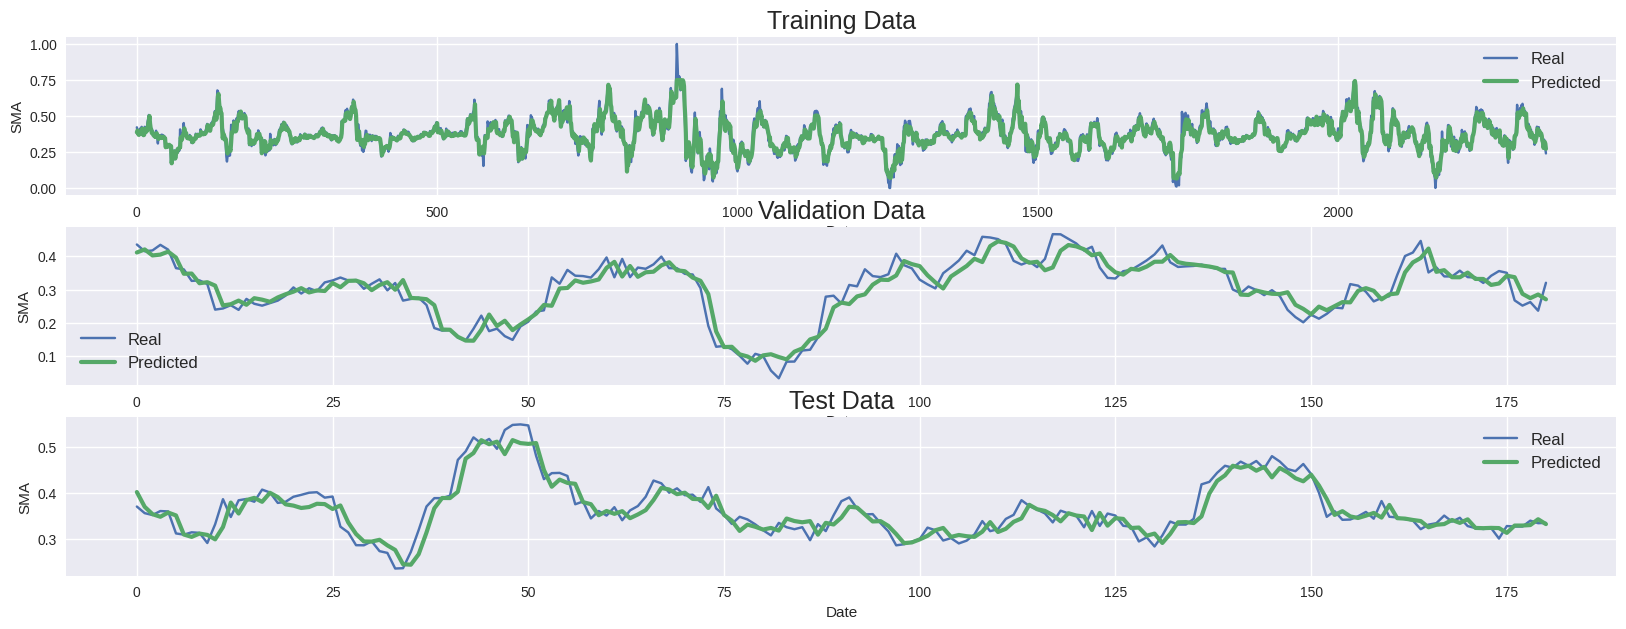

In [39]:
fig = plt.figure(figsize=(20,7))


#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(y_train, label='Real')
ax11.plot(train_pred, linewidth=3, label='Predicted')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('SMA')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(y_val, label='Real')
ax21.plot(val_pred, linewidth=3, label='Predicted')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('SMA')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(y_test, label='Real')
ax31.plot(test_pred, linewidth=3, label='Predicted')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('SMA')
ax31.legend(loc="best", fontsize=12)

In [54]:
#Print evaluation metrics for all datasets
print('Evaluation metrics')
print(' ')
train_eval = model.evaluate(X_train, y_train, verbose=0)
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
val_eval = model.evaluate(X_val, y_val, verbose=0)
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
test_eval = model.evaluate(X_test, y_test, verbose=0)
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

Evaluation metrics
 
Training Data - Loss: 0.0010, MAE: 0.0200, MAPE: 1977.5623
Validation Data - Loss: 0.0471, MAE: 0.1998, MAPE: 52.2462
Test Data - Loss: 0.0286, MAE: 0.1533, MAPE: 35.6308
